In [18]:
import torch
import torch.nn as nn
import numpy as np
import cv2

import matplotlib.pyplot as plt
%matplotlib inline

from scipy.signal import savgol_filter

from PIL import Image
import tqdm

In [19]:
segmentation_classes_colors = np.array([[64, 128, 64],[192, 0, 128],[0, 128, 192],[0, 128, 64],[128, 0, 0],[64, 0, 128],[64, 0, 192],[192, 128, 64],[192, 192, 128],[64, 64, 128],[128, 0, 192],[192, 0, 64],[128, 128, 64],[192, 0, 192],[128, 64, 64],[64, 192, 128],[64, 64, 0],	[128, 64, 128],[128, 128, 192],[0, 0, 192],	[192, 128, 128],[128, 128, 128],[64, 128, 192],[0, 0, 64],[0, 64, 64],[192, 64, 128],[128, 128, 0],[192, 128, 192],[64, 0, 64],[192, 192, 0],[0, 0, 0],[64, 192, 0]])

In [20]:
print("32 Colors for 32 Classes")
segmentation_classes_colors.shape

32 Colors for 32 Classes


(32, 3)

In [21]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
dtype_device = torch.cuda.FloatTensor if device.type == 'cuda' else torch.FloatTensor
device

device(type='cuda')

In [22]:
!wget http://mi.eng.cam.ac.uk/research/projects/VideoRec/CamSeq01/CamSeq01.zip

--2021-02-12 16:06:40--  http://mi.eng.cam.ac.uk/research/projects/VideoRec/CamSeq01/CamSeq01.zip
Resolving mi.eng.cam.ac.uk (mi.eng.cam.ac.uk)... 129.169.82.147
Connecting to mi.eng.cam.ac.uk (mi.eng.cam.ac.uk)|129.169.82.147|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 94535380 (90M) [application/zip]
Saving to: ‘CamSeq01.zip.1’

CamSeq01.zip.1      100%[===================>]  90.16M  53.2MB/s    in 1.7s    

2021-02-12 16:06:42 (53.2 MB/s) - ‘CamSeq01.zip.1’ saved [94535380/94535380]



In [23]:
!unzip CamSeq01.zip -d CamSeq01

Archive:  CamSeq01.zip
  inflating: CamSeq01/0016E5_07977_L.png  
  inflating: CamSeq01/0016E5_07979_L.png  
  inflating: CamSeq01/0016E5_07981_L.png  
  inflating: CamSeq01/0016E5_07983_L.png  
  inflating: CamSeq01/0016E5_07985_L.png  
  inflating: CamSeq01/0016E5_07987_L.png  
  inflating: CamSeq01/0016E5_07989_L.png  
  inflating: CamSeq01/0016E5_07991_L.png  
  inflating: CamSeq01/0016E5_07993_L.png  
  inflating: CamSeq01/0016E5_07995_L.png  
  inflating: CamSeq01/0016E5_07997_L.png  
  inflating: CamSeq01/0016E5_07999_L.png  
  inflating: CamSeq01/0016E5_08001_L.png  
  inflating: CamSeq01/0016E5_08003_L.png  
  inflating: CamSeq01/0016E5_08005_L.png  
  inflating: CamSeq01/0016E5_08007_L.png  
  inflating: CamSeq01/0016E5_08009_L.png  
  inflating: CamSeq01/0016E5_08011_L.png  
  inflating: CamSeq01/0016E5_08013_L.png  
  inflating: CamSeq01/0016E5_08015_L.png  
  inflating: CamSeq01/0016E5_08017_L.png  
  inflating: CamSeq01/0016E5_08019_L.png  
  inflating: CamSeq01/0016E5_08

In [24]:
!mkdir CamSeq01/image CamSeq01/mask

mkdir: cannot create directory ‘CamSeq01/image’: File exists
mkdir: cannot create directory ‘CamSeq01/mask’: File exists


# Seperate folders 
images : original <br>
masks : segmented

In [25]:
!mv ./CamSeq01/*_L.png ./CamSeq01/mask/

In [26]:
!mv ./CamSeq01/*.png ./CamSeq01/image/

In [27]:
import torch.utils.data as data
import glob
import os

class CamSeqDataset(data.Dataset):
    def __init__(self, folder_path):
        super(CamSeqDataset, self).__init__()
        self.img_files = glob.glob(os.path.join(folder_path,'image','*.png'))

        self.imgs = []
        self.mask_files = []
        self.masks = []
        for img_path in self.img_files:
            self.mask_files.append(os.path.join(folder_path,'mask',os.path.basename(img_path.replace(".png","_L.png")))) 
            
            image = cv2.imread(img_path)
            label = cv2.imread(self.mask_files[-1])
            image = cv2.resize(image, (256, 256), interpolation=cv2.INTER_AREA)
            label = cv2.resize(label, (256, 256), interpolation=cv2.INTER_AREA)
            n_classes = 32
            one_hot_label = np.zeros((256, 256, n_classes))
            for i, class_color in enumerate(segmentation_classes_colors):

                # Close colors pixels, no need for 3 channel dim since it's either 3 True, or 3 False 
                # and we need (256, 256) bool array for slicing one_hot 
                class_pixels = np.isclose(label[:,:,:3], class_color, rtol=0, atol=20)[:,:,0]
                one_hot_label[:, :, i][class_pixels] = 1
            
            self.imgs.append(image)
            self.masks.append(one_hot_label)

    def __getitem__(self, index):

        image = self.imgs[index]
        label = self.masks[index]
        
        image = torch.from_numpy(image).float().permute(2,0,1).to(device)
        label = torch.from_numpy(label).float().permute(2,0,1).to(device)
        return image, label 

    def __len__(self):
        return len(self.img_files)

In [28]:
class ResidualBottleneckModule(nn.Module):

    def __init__(self):
        
        super(ResidualBottleneckModule, self).__init__()
        self.bn_0 = nn.BatchNorm2d(13)
        self.relu_0 = nn.ReLU()
        
        self.conv_1x1_0 = nn.Conv2d(in_channels=13, out_channels=193, kernel_size=1, stride=1)

        self.bn_1 = nn.BatchNorm2d(193)
        self.relu_1 = nn.ReLU()

        self.conv_3x3_0 = nn.Conv2d(in_channels=193, out_channels=193, kernel_size=3, stride=2, padding=1)

        self.bn_2 = nn.BatchNorm2d(193)
        self.relu_2 = nn.ReLU()

        self.conv_1x1_1 = nn.Conv2d(in_channels=193, out_channels=193, kernel_size=1, stride=1)

        self.conv_3x3_1 = nn.Conv2d(in_channels=13, out_channels=193, kernel_size=3, stride=2, padding=1)

    def forward(self, input_batch):

        x_bn_0 = self.bn_0(input_batch)
        x_relu_0 = self.relu_0(x_bn_0)
        x_conv_3x3_1 = self.conv_3x3_1(x_relu_0)

        x = self.conv_1x1_0(x_relu_0)
        
        x = self.bn_1(x)
        x = self.relu_1(x)
        
        x = self.conv_3x3_0(x)
        
        x = self.bn_2(x)
        x = self.relu_2(x)

        x = self.conv_1x1_1(x)

        output = x_conv_3x3_1 + x

        return output

In [29]:
class BottleneckReductionModule(nn.Module):

    def __init__(self):

        super(BottleneckReductionModule, self).__init__()

        self.conv_3x3_0 = nn.Conv2d(in_channels=13, out_channels=193, kernel_size=3, stride=8)
        self.relu_0 = nn.ReLU()
        self.conv_1x1 = nn.Conv2d(in_channels=193, out_channels=193, kernel_size=1, stride=1)
        self.relu_1 = nn.ReLU()
        self.conv_3x3_1 = nn.Conv2d(in_channels=193, out_channels=193, kernel_size=3, stride=1, padding=1)

    def forward(self, input_batch):

        x = self.conv_3x3_0(input_batch)

        x = self.relu_0(x)
        x = self.conv_1x1(x)
        x = self.relu_1(x)
        x = self.conv_3x3_1(x)

        return x

In [30]:
class RefineModule(nn.Module):

    def __init__(self, in_channels, out_channels):

        super(RefineModule, self).__init__()
        
        self.conv_1x1_0 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1)
        self.conv_1x1_1 = nn.Conv2d(out_channels, out_channels, kernel_size=1, stride=1)
        self.relu_0 = nn.ReLU()
        self.conv_3x3_0 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.relu_1 = nn.ReLU()
        self.conv_3x3_1 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)

    def forward(self, input_batch):

        x_conv_1x1_0 = self.conv_1x1_0(input_batch)

        x = self.conv_1x1_1(x_conv_1x1_0)
        x = self.relu_0(x)
        x = self.conv_3x3_0(x)
        x = self.relu_1(x)
        x = self.conv_3x3_1(x)

        return x + x_conv_1x1_0

In [31]:
class BilinearResizeModule(nn.Module):

    def __init__(self, scale_factor):

        super(BilinearResizeModule, self).__init__()

        self.upsample = nn.UpsamplingBilinear2d(scale_factor=scale_factor)

    def forward(self, input_batch):

        x = self.upsample(input_batch)
        return x

In [32]:
class EdgeSegNet(nn.Module):

    def __init__(self):

        super(EdgeSegNet, self).__init__()

        self.conv_7x7 = nn.Conv2d(in_channels=3, out_channels=13, kernel_size=7, stride=2, padding=3)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Top part of the graph, before the first addition of (32, 32, 193)
        self.bottleneck_module = BottleneckReductionModule()
        self.bilinear_resize_x2_0 = BilinearResizeModule(scale_factor=2)

        # Bottom part of the graph, before the first addition of (32, 32, 193)
        self.residual_module = ResidualBottleneckModule()
        self.refine_module_0 = RefineModule(in_channels=193, out_channels=193)

        # Top part of the graph, after the first addition of (32, 32, 193)
        self.refine_module_1 = RefineModule(in_channels=193, out_channels=217)
        self.bilinear_resize_x2_1 = BilinearResizeModule(scale_factor=2)

        # Bottom part of the graph, maxpool to (64, 64, 217) addition
        self.refine_module_2 = RefineModule(in_channels=13, out_channels=217)

        # After the (64, 64, 217) addition
        self.refine_module_3 = RefineModule(in_channels=217, out_channels=217)
        self.bilinear_resize_x4 = BilinearResizeModule(scale_factor=4)
        self.conv_1x1 = nn.Conv2d(in_channels=217, out_channels=32, kernel_size=1, stride=1)

    def forward(self, input_batch):
        
        x_conv_7x7 = self.conv_7x7(input_batch)
        x_maxpool = self.maxpool(x_conv_7x7)

        x_top = self.bottleneck_module(x_conv_7x7)
        x_top = self.bilinear_resize_x2_0(x_top)

        x_bottom = self.residual_module(x_maxpool)
        x_bottom = self.refine_module_0(x_bottom)

        # (32, 32, 193) addition
        x_top = x_top + x_bottom
        x_top = self.refine_module_1(x_top)
        x_top = self.bilinear_resize_x2_1(x_top)

        x_bottom = self.refine_module_2(x_maxpool)

        # (64, 64, 217) addition
        x_top = x_top + x_bottom

        x_top = self.refine_module_3(x_top)
        x_top = self.bilinear_resize_x4(x_top)
        x_top = self.conv_1x1(x_top)

        return x_top

In [33]:
def train_model(model,train_loader,validation_loader,optimizer,criterion,scheduler=None, n_epochs=4):
    
    accuracy_train_list = [0]
    loss_train_list = [float("inf")]

    accuracy_val_list = [0]
    loss_val_list = [float("inf")]
    train_batch_size = None
    val_batch_size = None
    num_epoch_batches = 0
    
    for epoch in range(n_epochs):

        progress_bar = tqdm.tqdm(train_loader,leave=True,position=0)

        for batch_idx, batch in enumerate(progress_bar):

            batch_loss = round(loss_train_list[-1], 4)
            batch_acc = round(accuracy_train_list[-1], 4)
            
            batch_loss_val = round(loss_val_list[-1], 4)
            batch_acc_val = round(accuracy_val_list[-1], 4)

            stats_dict = {
            'Batch Loss' : f"{batch_loss} ",
            'Acc' : f"{batch_acc} ",
            'Batch Loss Val' : f"{batch_loss_val}",
            'Acc Val' : f"{batch_acc_val}"
            }

            progress_bar.set_description(f'Epoch {epoch} / {n_epochs}')
            progress_bar.set_postfix(stats_dict)


            images_batch, labels_batch = batch

            optimizer.zero_grad()

            model.train()
            outputs_batch = model(images_batch)

            # CrossEntropyLoss expects target of (batch, d0, ...) of class values with no channels
            # outputs_batch of shape (batch, channel, d0, ...) of logit values
            _, labels_max = torch.max(labels_batch.data, 1)
            loss = criterion(outputs_batch, labels_max.long())

            loss.backward()
            
            if scheduler is not None:
                scheduler.step()
            else:
                optimizer.step()

            loss_train_list.append(torch.clone(loss).detach().item())

            correct = 0.
            total = 0.
            with torch.no_grad():
                for batch in train_loader:
                    images, labels = batch
                    model.eval()
                    outputs = model(images)
                    total += labels.size(0) * 256 * 256

                    _, predicted = torch.max(nn.functional.softmax(outputs, dim=1).data, 1)
                    _, labels = torch.max(labels.data, 1)
                    
                    correct += (predicted == labels).sum().item()
            
            accuracy_train_list.append(correct/total)

        for batch in validation_loader:

            images_batch, labels_batch = batch

            optimizer.zero_grad()

            model.train()
            outputs_batch = model(images_batch)

            # CrossEntropyLoss expects target of (batch, d0, ...) of class values with no channels
            # outputs_batch of shape (batch, channel, d0, ...) of logit values
            _, labels_max = torch.max(labels_batch.data, 1)
            loss = criterion(outputs_batch, labels_max.long())

            # No backward, No optim.step

            loss_val_list.append(torch.clone(loss).detach().item())

            correct = 0.
            total = 0.
            with torch.no_grad():
                for batch in validation_loader:
                    images, labels = batch
                    model.eval()
                    outputs = model(images)
                    total += labels.size(0) * 256 * 256

                    _, predicted = torch.max(nn.functional.softmax(outputs, dim=1).data, 1)
                    _, labels = torch.max(labels.data, 1)
                    
                    correct += (predicted == labels).sum().item()
            
            accuracy_val_list.append(correct/total)

    return loss_train_list, accuracy_train_list, loss_val_list, accuracy_val_list

In [35]:
dataset = CamSeqDataset("./CamSeq01")

# We can provide class weights to CrossEntropyLoss 
# to discourage bias for over-represented (majority of pixels) classes (ex. sky, road ..)

class_weights_loader = torch.utils.data.DataLoader(dataset, batch_size=101)
dataset_labels = next(iter(class_weights_loader))[1]
class_representation_sum = dataset_labels.sum(dim=0).sum(dim=1).sum(dim=1)
dataset_labels = None
total_pixels = class_representation_sum.sum()
class_weights = class_representation_sum/total_pixels

###################################### DataLoaders ########################################
train_set, val_set = torch.utils.data.random_split(dataset, [71, 30])

train_loader = torch.utils.data.DataLoader(train_set, batch_size=16, shuffle=True)
test_loader = torch.utils.data.DataLoader(val_set, batch_size=16, shuffle=True)

####################################### Model ########################################
model = EdgeSegNet()
model.to(device)

optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.95)

criterion = nn.CrossEntropyLoss(weight=class_weights)

global_loss_train_list = []
global_accuracy_train_list = []

global_loss_val_list = []
global_accuracy_val_list = []

In [36]:
loss_train_list, accuracy_train_list, loss_val_list, accuracy_val_list = train_model(
    model, 
    train_loader, 
    test_loader, 
    optimizer, 
    criterion, 
    n_epochs=50
)

global_loss_train_list.extend(loss_train_list)
global_accuracy_train_list.extend(accuracy_train_list)

global_loss_val_list.extend(loss_val_list)
global_accuracy_val_list.extend(accuracy_val_list)

Epoch 49 / 50: 100%|██████████| 5/5 [00:03<00:00,  1.31it/s, Batch Loss=0.1027, Acc=0.914, Batch Loss Val=0.1247, Acc Val=0.8935]


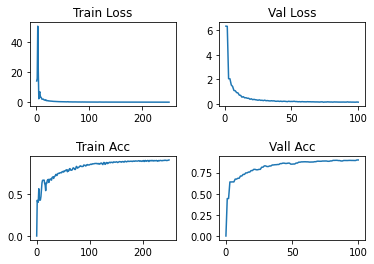

In [37]:
# window = len(global_accuracy_train_list)
# window = window - 1 if window % 2 == 0 else window
# smooth_global_accuracy_train_list = savgol_filter(global_accuracy_train_list, window, 3)

plt.subplot(2, 2, 1).set_title("Train Loss")
plt.plot(global_loss_train_list)

plt.subplot(2, 2, 2).set_title("Val Loss")
plt.plot(global_loss_val_list)

plt.subplot(2, 2, 3).set_title("Train Acc")
plt.plot(global_accuracy_train_list)

plt.subplot(2, 2, 4).set_title("Vall Acc")
plt.plot(global_accuracy_val_list)

plt.subplots_adjust(hspace=0.6, wspace=0.3)

In [39]:
def semantic_to_rgb(labeld_image):

    max_idx = torch.argmax(labeld_image, 0, keepdim=True)
    max_idx.shape
    rgb_img = np.zeros((256, 256, 3))

    for i, class_color in enumerate(segmentation_classes_colors):

        class_pixels = torch.eq(max_idx, torch.tensor([i]).to(device))
        rgb_img[:, :, :3][class_pixels.squeeze(0).cpu().detach().numpy()] = class_color
    return rgb_img

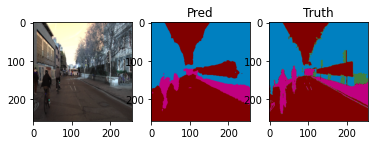

In [40]:
image, ture_label = dataset[100]

model.eval()

label = model(image.unsqueeze(0))
label = nn.functional.softmax(label, dim=1).squeeze(0)

rgb_img = semantic_to_rgb(label)

np_image = image.permute(1,2,0).cpu().detach().numpy()
plt.subplot(1, 3, 1)
plt.imshow(np_image.astype(np.uint8))

plt.subplot(1, 3, 2).set_title("Pred")

plt.imshow((rgb_img).astype(np.uint8))

plt.subplot(1, 3, 3).set_title("Truth")

rgb_img = semantic_to_rgb(ture_label)

plt.imshow((rgb_img).astype(np.uint8))
